# [Dense layer 관련 개념](https://tykimos.github.io/2017/01/27/MLP_Layer_Talk/)
# [손실 함수 개념](https://truman.tistory.com/164#:~:text=%EC%86%90%EC%8B%A4%20%ED%95%A8%EC%88%98%EB%8A%94%20%EC%8B%A4%EC%A0%9C%EA%B0%92,%EC%B0%BE%EC%95%84%EA%B0%80%EB%8A%94%EA%B2%83%EC%9D%B4%20%ED%95%99%EC%8A%B5%20%EB%AA%A9%ED%91%9C%EC%9D%B4%EB%8B%A4.)

# 자동차 연비 예측하기 : 회귀

본 튜토리얼은 [구글 공식 텐서플로우 튜토리얼](https://www.tensorflow.org/tutorials/keras/regression)를 참고하여 작성되었습니다.

회귀(regression)는 가격이나 확률 같이 연속된 출력 값을 예측하는 것이 목적입니다. 이와 달리 분류(classification)는 여러개의 클래스 중 하나의 클래스를 선택하는 것이 목적입니다. 앞선 튜토리얼에서는 패션 분류와 영화 리뷰 이진 분류를 해보았습니다. 이번 튜토리얼에서는 회귀에 대해 알아보겠습니다.

이번 튜토리얼에서는 [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) 데이터셋을 사용하여 1970년대 후반과 1980년대 초반의 자동차 연비를 예측하는 모델을 만들 것입니다. 이 기간에 출시된 자동차 정보를 모델에 제공하겠습니다. 자동차 정보에는 실린더 수, 배기량, 마력, 공차 중량 같은 속성이 포함됩니다.

In [1]:
# 산점도 행렬을 그리기 위해 seaborn 패키지를 설치합니다.
!pip install seaborn

In [2]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 1. Auto MPG 데이터셋

### 데이터 구하기

[UCI 머신 러닝 저장소](https://archive.ics.uci.edu/ml/)에서 Auto MPG 데이터셋을 다운로드합니다.

In [3]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 0us/step


'/root/.keras/datasets/auto-mpg.data'

pandas를 사용하여 데이터를 읽습니다.

+ [pandas](https://rfriend.tistory.com/250) : 외부 text 파일, csv 파일을 불러와서 DataFrame으로 저장할 때 사용한다. 

In [4]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 
                'Weight', 'Acceleration', 'Model Year', 'Origin']
# pandas(pd)를 사용하여 다운로드한 데이터(dataset_path)를 column_names에 따라 읽습니다.
raw_dataset = pd.read_csv(dataset_path, names=column_names, 
                          na_values="?", comment='\t', 
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()  # 날것의 데이터
dataset.tail()  # 데이터셋의 마지막 n행들을 리턴합니다.

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### 데이터 정제하기

이 데이터셋은 일부 데이터가 누락되어 있습니다.

In [5]:
dataset.isna().sum()  # 누락된 데이터의 개수를 나타냅니다.

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

누락된 행을 삭제하겠습니다.

In [6]:
dataset = dataset.dropna()

마지막 `"Origin"`열은 원산지를 의미합니다.

+ 1 : USA
+ 2 : Europe
+ 3 : Japan
 
Origin 열을 지운 후 3개의 국가를 열로 추가한 뒤에 숫자에 해당하는 행을 1.0, 해당하지 않는 행들을 0.0으로 표시하는 원-핫 인코딩(one-hot encoding)으로 변환하겠습니다.

In [7]:
origin = dataset.pop('Origin')  # Origin 열을 지웁니다.

In [8]:
dataset['USA'] = (origin == 1)*1.0  # USA 열을 추가하며, 기존 Origin에서 1이었던 행들의 값을 1.0으로 지정합니다.
dataset['Europe'] = (origin == 2)*1.0  # Europe 열을 추가하며, 기존 Origin에서 2였던 행들의 값을 1.0으로 지정합니다.
dataset['Japan'] = (origin == 3)*1.0  # Japan 열을 추가하며, 기존 Origin에서 3이었던 행들의 값을 1.0으로 지정합니다.
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 데이터셋을 훈련 세트와 테스트 세트로 분할하기

이제 데이터를 훈련 세트와 테스트 세트로 분할합니다.

테스트 세트는 모델을 최종적으로 평가할 때 사용합니다.

In [9]:
# dataset을 8(훈련 세트) : 2(테스트 세트)로 분할합니다.
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### 데이터 조사하기

훈련 세트에서 몇 개의 열을 선택해 산점도 행렬을 만들어 살펴 보겠습니다.

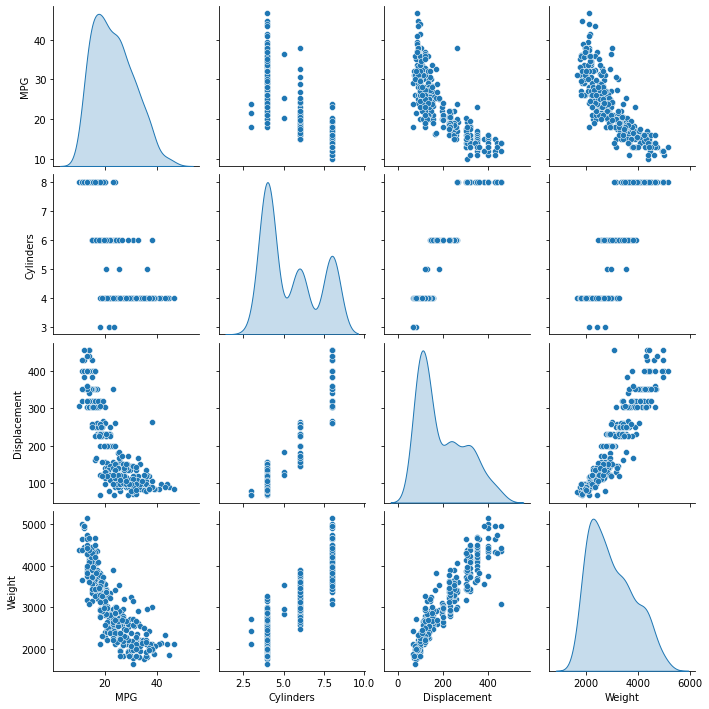

In [10]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

전반적인 통계도 확인해봅시다.

In [11]:
train_stats = train_dataset.describe()  # 값들의 최소, 25%, 50%, 75%, 최대의 통계값들을 열로 추가해 나타낸다. 
train_stats.pop("MPG")
train_stats = train_stats.transpose()  # 행과 열을 바꾼다.
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### 특성과 레이블 분리하기

특성에서 타깃 값 또는 "레이블"을 분리합니다.

In [12]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

### 데이터 정규화

위 `train_stats` 통계를 다시 살펴보고 각 특성의 범위가 얼마나 다른지 확인해 보겠습니다.

특성의 스케일과 범위가 다르면 [정규화(normalization)](https://mangkyu.tistory.com/110)하는 것이 권장됩니다. 특성을 정규화하지 않아도 모델이 수렴할 수 있지만, 훈련시키기 어렵고 입력 단위에 의존적인 모델이 만들어집니다.

앞서 훈련 세트만 사용하여 통계치를 생성했습니다. 이 통계는 테스트 세트를 정규화할 때도 사용됩니다. 테스트 세트를 모델이 훈련에 사용했던 것과 동일한 분포로 투영하기 위함입니다. 

In [13]:
def norm(x):
    # mean : 평균, std : 표준편차
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

정규화된 훈련 세트와 테스트 세트를 사용하여 모델을 훈련합니다.

입력 데이터를 정규화하기 위해 사용한 통계치(평균과 표준편차)는 모든 데이터(테스트 세트, 실전에서의 라이브 데이터)에 적용되어야 합니다.

## 2. 모델

### 모델 만들기

이번에는 두 개의 완전 연결 은닉층으로 `Sequential` 모델을 만들어보겠습니다. 출력 층은 하나의 연속적인 값을 반환합니다.

다른 모델들을 만들 때 간편하도록 Layer 쌓기와 모델 컴파일 과정을 `build_model` 함수로 만들겠습니다.

In [14]:
def build_model():
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(1))

    model.compile(loss='mse',  # 손실 함수
                  optimizer=tf.keras.optimizers.RMSprop(0.001),  # 옵티마이저
                  metrics=['mae', 'mse'])  # 정확도
    return model

In [15]:
model = build_model()

### 모델 확인

`.summary` 메서드를 사용해 모델에 대한 간단한 정보를 출력합니다.

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


모델을 한 번 실행해보겠습니다. 정규화된 훈련 세트에서 10개의 샘플을 batch로 만들어 이 batch에 대해 모델 예측을 해보겠습니다.

In [17]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.34468493],
       [-0.22123677],
       [-0.01795089],
       [-0.2849781 ],
       [-0.03345388],
       [-0.03453297],
       [-0.02613711],
       [ 0.15187424],
       [-0.03678229],
       [-0.51473004]], dtype=float32)

### 모델 훈련

이 모델을 훈련 세트를 통해 1,000번 반복 훈련합니다. 훈련 정확도와 검증 정확도는 `history`객체에 기록됩니다.

In [18]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

history = model.fit(normed_train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

`history` 객체에 저장된 통계치를 사용해 모델의 훈련 과정을 시각화해봅시다.

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.191843,0.903681,2.191843,9.058786,2.250379,9.058786,995
996,2.051978,0.815753,2.051978,8.866919,2.243108,8.866919,996
997,2.350475,0.935651,2.350475,8.610909,2.200367,8.610909,997
998,2.067452,0.849525,2.067452,8.346190,2.181779,8.346190,998
999,2.145907,0.849340,2.145907,9.018305,2.301047,9.018305,999


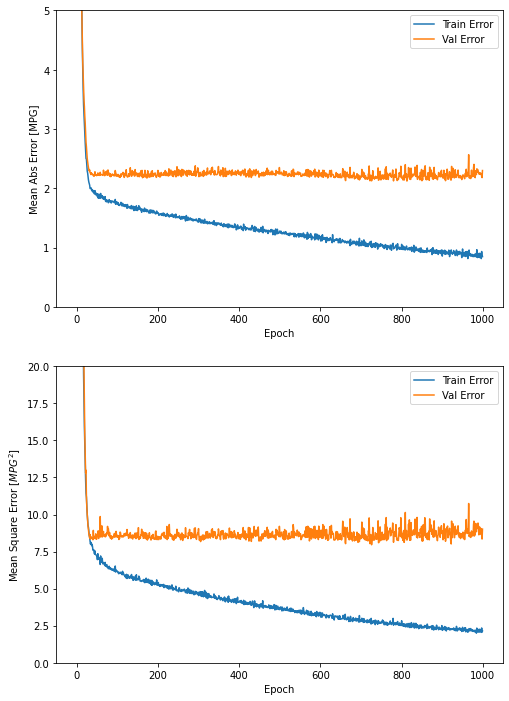

In [20]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8,12))

    plt.subplot(2, 1, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

mae, mse는 정확도의 척도입니다. 낮을 수록 정확도가 높아지는 것을 뜻하는데, 그래프 상으로 수백번의 에포크를 진행한 이후에는 모델이 거의 향상되지 않는 것 같습니다.

따라서 `model.fit` 메서드를 수정하여 검증 점수(Val loss)가 향상되지 않으면 자동으로 훈련을 멈추도록 만들어보겠습니다.

에포크마다 훈련 상태를 점검하기 위해 Earlystopping callback을 사용하겠습니다. 지정된 에포크 횟수 동안 성능 향상이 없으면 자동으로 훈련이 멈춥니다.


....................................................................................................
..........................

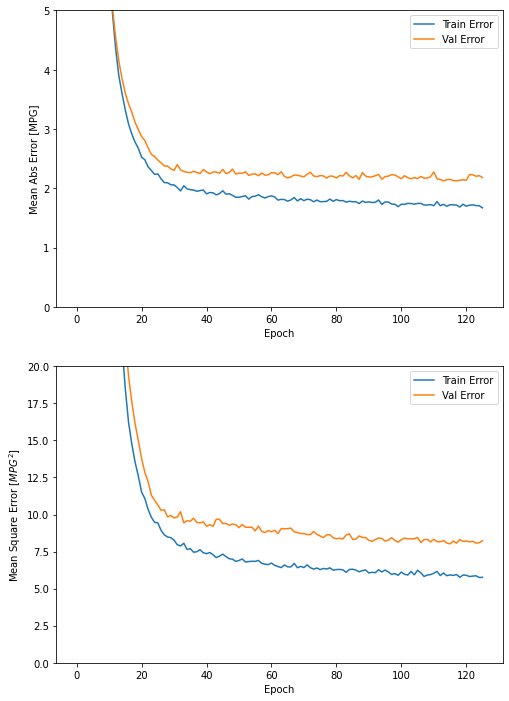

In [21]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=1000,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

이제 테스트 세트를 이용해 모델의 성능을 확인해보겠습니다. 모델이 실전에 투입되었을 때 모델의 성능을 짐작할 수 있습니다.

In [22]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.7240 - mae: 1.8562 - mse: 5.7240
테스트 세트의 평균 절대 오차:  1.86 MPG


## 3. 테스트 세트 예측하기

마지막으로 테스트 세트에 있는 샘플을 사용해 MPG 값을 예측해 보겠습니다.



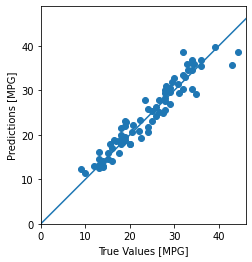

In [23]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

모델이 꽤 잘 예측한 것 같습니다. 오차의 분포를 살펴보겠습니다.

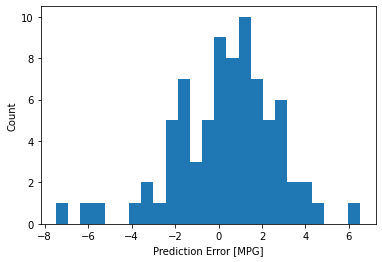

In [24]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## 4. 결론

+ **평균 제곱 오차(MSE)**: 회귀 문제에서 자주 사용되는 손실 함수입니다.
+ **평균 절댓값 오차(MAE)**: 회귀에서 자주 사용되는 평가 지표입니다.
+ **정규화**: 수치 입력 데이터의 특성이 여러 가지 범위를 가질 때 동일한 범위가 되도록 각 특성의 스케일을 독립적으로 조정해야 합니다.
+ 훈련 데이터가 많지 않다면 과대적합을 피하기 위해 은닉층의 개수가 적은 **소규모 신경망을 선택**하는 방법이 좋습니다.
+ **Early stopping callback**은 과대적합을 방지하기 위한 좋은 방법입니다.